# Software profesional en Acústica 2020-21 (M2i)

*This notebook contains a modification of the notebook [ElasticBarLinearFEM](https://github.com/garth-wells/notebooks-3D7), used in the course **3D7 Finite Element Methods** in the University of Cambridge, and created by Garth N. Wells. The code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# Finite element method

We create in this notebook a simple finite element solver for the Helmholtz equation with piecewise linear finite elements. We will use **NumPy** and **SciPy** to perform the simulations, and **Matplotlib** to visualise the results, so we first import the **NumPy** and **Matplotlib** modules:

In [19]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Setting matplotlib
plt.style.use('seaborn-poster')
%matplotlib inline

## Statement of the problem

Solve the Helmholtz problem using the finite element method, and plot the numerical approximation. The ODE is
$$ -\frac{d^2u}{dx^2} - k^2u = f$$
with the boundary conditions $u(0) = 0$ and $u(\pi) = 0$ and source term $f(x)=1$. Let's take $n=10$. 

### Wavenumber and Source term
We now define the source term $f$. We will use a function that takes the coordinate $x$ as an argument so we possibly define loading terms that vary with position.

In [20]:
k = 1.5 # wavenumber
def distributed_load(x):
    return 1.0

### Mesh
We will create a mesh of length $L$ with a prescribed number of cells (elements) $n_{\text{cells}}$. For linear elements, the number of nodes $n_{\text{nodes}}$ is equal to $n_{\text{cells}} + 1$.

In [21]:
L = np.pi
n_cells = 10
n_nodes = n_cells + 1

To create a mesh from 0 to $L$ with equal size cells (elements) we will use the NumPy function `linspace` to generate an array of equally spaced points on the interval $[0, L]$.

In [22]:
mesh = np.linspace(0.0, L, n_nodes)

Matplotlib can be used to visualise the mesh:

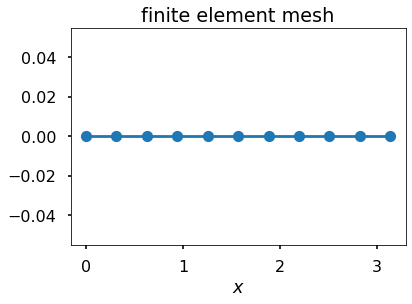

In [23]:
plt.xlabel('$x$')
plt.title('finite element mesh')
plt.plot(mesh, [0]*len(mesh), 'o-');

### A simple finite element solver

We have already defined our domain (the mesh) and the wavenumber $k$. We now need to build the global stiffness and mass matrix $K$ and $M$, respectively, and the global right-hand side vector $\vec{b}$, after which we can solve $(K+k^2M) \vec{u} = \vec{b}$ to get the nodal degrees-of-freedom $\vec{u}$. 

#### Create stiffness matrix $\boldsymbol{K}$

We create the global stiffness matrix by computing the element matrix $K_{e}$ , and then looping over all cells and adding their contribution to the global matrix.

##### Element stiffness matrix $\boldsymbol{K}_{e}$

The element stiffness matrix for a linear element is
$$
K_{e} 
= \frac{1}{h}
\begin{bmatrix}
1 & -1 \\ -1 & 1    
\end{bmatrix}
$$
where $h$ is the mesh size.
Our mesh has constant mesh size, so we can compute $K_{e}$ just once:

In [24]:
h = L/n_cells
k_e = (1./h)*np.array([[1, -1], [-1, 1]])
print(k_e)

[[ 3.18309886 -3.18309886]
 [-3.18309886  3.18309886]]


#### Create mass matrix $\boldsymbol{M}$

We create the global mass matrix by computing the element matrix $M_{e}$ , and then looping over all cells and adding their contribution to the global matrix.

##### Element mass matrix $\boldsymbol{M}_{e}$

The element mass matrix for a linear element is
$$
M_{e} 
= \frac{h}{6}
\begin{bmatrix}
2 & 1 \\ 1 & 2    
\end{bmatrix}
$$
where $h$ is the mesh size.
Our mesh has constant mesh size, so we can compute $M_{e}$ just once:

In [25]:
h = L/n_cells
m_e = (h/6.)*np.array([[2, 1], [1, 2]])
print(m_e)

[[0.10471976 0.05235988]
 [0.05235988 0.10471976]]


##### Assemble global (ans sparse) stiffness and mass matrices

To build the global stiffness and mass matrices $K$ and $M$, we first create an empty $n_{\text{nodes}} \times n_{\text{nodes}}$ matrix: 

In [26]:
# import sparse module from SciPy package 
from scipy import sparse
K = sparse.csr_matrix((n_nodes, n_nodes))
M = sparse.csr_matrix((n_nodes, n_nodes))

Next, we loop over each cell and add the cell contribution $K_{e}$ to the global matrix $K$ (analogously $M_e$ to the global matrix $M$). This is known as *assembly*. 

In [27]:
for element in range(n_cells):
    K[element:element + 2, element:element + 2] += k_e
    M[element:element + 2, element:element + 2] += m_e
print(K.toarray())

[[ 3.18309886 -3.18309886  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [-3.18309886  6.36619772 -3.18309886  0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.         -3.18309886  6.36619772 -3.18309886  0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.         -3.18309886  6.36619772 -3.18309886  0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -3.18309886  6.36619772 -3.18309886
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -3.18309886  6.36619772
  -3.18309886  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -3.18309886
   6.36619772 -3.18309886  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -3.18

/usr/local/lib/python3.8/dist-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


#### Create RHS vector $\boldsymbol{b}$

We create the global RHS vector $\vec{b}$ by computing the cell RHS $\vec{b}_{e}$ cell-by-cell, and adding this to the global RHS vector. We allow the distributed load $f$ to vary with position, which is why we cannot compute it just once. For simplicity we will integrate the local RHS using the midpoint rule. This is exact if $f$ is constant, and is otherwise approximate.

We first create an empty global RHS vector: 

In [28]:
b = np.zeros(n_nodes)

We now loop over each cell and compute $\int_{x_{i}}^{x_{i+1}} N_{1} f dx=hf(x_{i+\frac12})$ and $\int_{x_{i}}^{x_{i+1}} N_{2} f dx=hf(x_{i+\frac12})$ for each cell, and add the contribution to the global RHS vector: 

In [29]:
for element in range(n_cells):

    # Get cell length and midpoint
    h     = mesh[element + 1] - mesh[element]   
    x_mid = (mesh[element + 1] + mesh[element])/2.0
    
    # Evaluate loading term
    f = distributed_load(x_mid)

    # Compute and add RHS contributions
    b[element:element + 2] += 0.5*h*f

#### Apply Dirichet (displacement) boundary condition

We're almost ready to solve a finite element problem, but we would get into trouble if we tried to solve $A \vec{u} = \vec{b}$ using the above stiffness matrix because it is singular (you can verify this by computing its determinant). The system is singular because we have not applied a Dirichlet boundary condition, and hence multiple solutions are possible.

We impose the boundary condition $u = 0$ and $x=0$ by zeroing the first row and column of the matrix, placing a one on the first diagonal entry and setting the first entry on the RHS to zero. It should be clear algebraically that this will ensure that the first degree of freedom is equal to zero when we solve the system.

[0.         0.31415927 0.31415927 0.31415927 0.31415927 0.31415927
 0.31415927 0.31415927 0.31415927 0.31415927 0.        ]
[[ 1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [-3.30090859  5.89495883 -3.30090859  0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.         -3.30090859  5.89495883 -3.30090859  0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.         -3.30090859  5.89495883 -3.30090859  0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -3.30090859  5.89495883 -3.30090859
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -3.30090859  5.89495883
  -3.30090859  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -3.30090859
   5.8949588

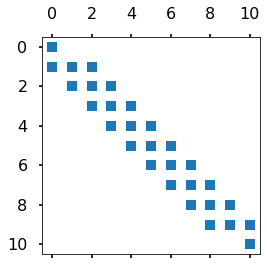

In [30]:
# Get discretization matrix
A = K - k**2*M

# Block the boundary conditions on b
b[0] = 0.
b[-1] = 0.
print(b)

# Block the boundary conditions on A
A[0,0] = 1.; A[0,1] = 0.
A[-1,-1] = 1.; A[-1,-2] = 0.
print(A.toarray())

# Plot sparse patern
import matplotlib as mp
import matplotlib.pyplot as plt
plt.spy(A)
plt.show()

#### Solve system of equations

We can now solve the finite element system $\boldsymbol{K}$:

In [31]:
from scipy.sparse.linalg import spsolve
u = spsolve(A, b)

#### Visualising the solution

We now plot the solution:

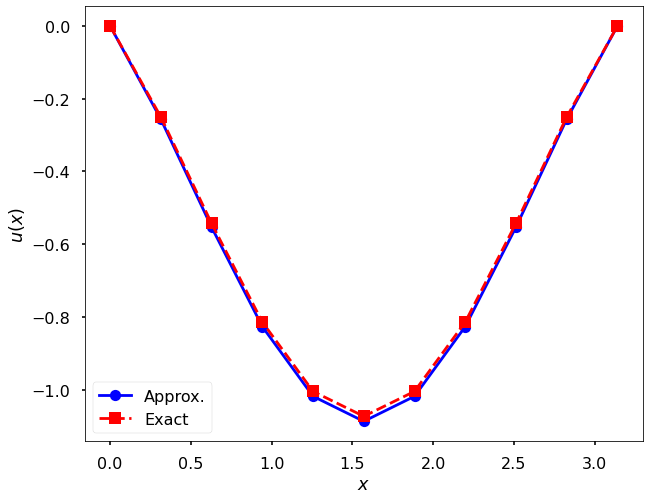

In [32]:
# Plot the solution
x = np.linspace(0, L, n_cells+1)
plt.figure(figsize=(10,8))
plt.plot(x, u, 'bo-')
plt.plot(x, (np.cos(k*(x-np.pi/2))/np.cos(k*np.pi/2) -1)/k**2, 'rs--')
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x)$')
plt.legend(['Approx.','Exact'])
plt.show()

## A more programmatic approach

We now present a finite element solver that is very similar the one above, but we now provide a programming interface so we can reuse a function to explore different loading functions and different levels of refinement of the mesh.

If we use matrix notation, the finite element discretization can be read as a particular case of a finite difference method (in 1D only!), we will have:

$$
\left(\begin{bmatrix}
1 & 0 & & & \\
1 & -2 & 1 & &  \\
 & \ddots & \ddots & \ddots & \\
 & & 1& -2& 1 \\
 & & & 0 & 1
\end{bmatrix}
+
\frac{k^2h^2}{6}
\begin{bmatrix}
0 & 0 & & & \\
2 & 4 & 2 & &  \\
 & \ddots & \ddots & \ddots & \\
 & & 2& 4& 2 \\
 & & & 0 & 0
\end{bmatrix}
\right)
\left[\begin{array}{c} u_0 \\u_1 \\ ... \\ u_{n-1}\\u_n \end{array}\right] =
\left[\begin{array}{c} 0 \\0 \\ ... \\ 0 \\1\end{array}\right]$$

Therefore, we have $n+1$ equations in the system, we can store it using a sparse matrix (tridiagonal), and solve it using the sparse linear solver included in ``scipy``. 

In [33]:
def compute_fem(L, k, f_source, n_cells, quad_degree=3):

    # Crarte mesh and compute cell size
    n_nodes = n_cells + 1
    mesh = np.linspace(0.0, L, n_nodes)
    h = L/n_cells

    # Compute locall stiffness matrix
    k_e = np.array([[1, -1], [-1, 1]])/h
    m_e = h*np.array([[2, 1], [1, 2]])/6
    
    # Assemble global stiffnes matrix
    K = sparse.csr_matrix((n_nodes, n_nodes))
    M = sparse.csr_matrix((n_nodes, n_nodes))
    for element in range(n_cells):
        K[element:element + 2, element:element + 2] += k_e
        M[element:element + 2, element:element + 2] += m_e
    
    # Assemble RHS using Gauss quadrature
    b = np.zeros(n_nodes)    
    for element in range(n_cells):

        # Get cell length and midpoint
        h     = mesh[element + 1] - mesh[element]   
        x_mid = (mesh[element + 1] + mesh[element])/2.0
    
        # Evaluate loading term
        f = distributed_load(x_mid)

        # Compute and add RHS contributions
        b[element:element + 2] += 0.5*h*f

    # Get discretization matrix
    A = K - k**2*M

    # Block the boundary conditions on b
    b[0] = 0.
    b[-1] = 0.

    # Block the boundary conditions on A
    A[0,0] = 1.; A[0,1] = 0.
    A[-1,-1] = 1.; A[-1,-2] = 0.
    
    return spsolve(A, b), mesh

def compute_exact(L, k, n_cells):
    # Physical setting
    x = np.linspace(0, L, n_cells+1)
    return (np.cos(k*(x-L/2))/np.cos(k*L/2) -1)/k**2, x

We want to see how the error is decreasing as soon as $h$ tends to zero:

/usr/local/lib/python3.8/dist-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


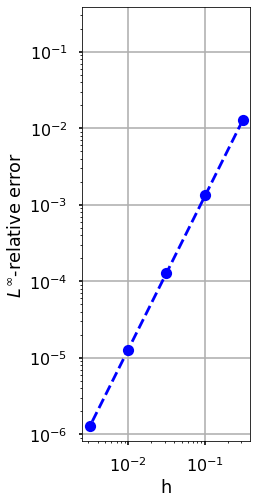

In [34]:
nvec = np.int_(np.logspace(1,3,5))
error = np.zeros(len(nvec))
for j,n in enumerate(nvec):
    uh, mesh = compute_fem(L, k, distributed_load, n)
    uex, mesh_ex = compute_exact(L, k, n)
    error[j] = np.linalg.norm(uh-uex,np.inf)/np.linalg.norm(uex,np.inf)
    
plt.figure(figsize = (10,8))
plt.loglog(L/nvec, error, 'bo--')
plt.xlabel('h')
plt.ylabel(r'$L^\infty$-relative error')
plt.axis("square")
plt.grid()
plt.show()

### Interactive solver

We can make an interactive solver, where you can change the number of cells via a slider and see how the solution changes.
You need to run this notebook in a Jupyter session to see and use the slider.

In [35]:
from ipywidgets import widgets
from ipywidgets import interact

# Compute reference solution with 100 cells
u_ex, mesh_ex = compute_exact(L, k, 100)

@interact(num_cells=widgets.IntSlider(min=1, max=20, value=5, description='number of cells'))
def plot(num_cells=5):
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    plt.title('Finite element solution for the Helmholtz equation')
    uh, mesh = compute_fem(L, k, distributed_load, num_cells)
    plt.plot(mesh_ex, u_ex, '--', color='k', label='Exact');
    plt.plot(mesh, uh, 'o-', label='Approx. : ' + str(len(mesh)-1) + ' cells');
    plt.legend(loc='upper left');

interactive(children=(IntSlider(value=5, description='number of cells', max=20, min=1), Output()), _dom_classe…

### Exercise
Re-implement the FEM function ``compute_fem`` taking into account the finite difference analogy between FEM and FD discretization in 1D. For different values of grid nodes, compare the error values and the order of convergence in FEM and FD discretization: in this case, which is the method providing the best results?

In [36]:
## YOUR CODE HERE